# FINAL VERSION

# Initialization

In [ ]:
# Once you have imported the environment (gym-Didi-NN8), comment these lines and reset the runtime before to execute the rest of the code

!pip install -e /path/gym-Didi-NN8
!pip install keras-rl
!pip install git+git://github.com/wau/keras-rl2.git --upgrade --no-deps
!pip install git+git://github.com/fchollet/keras.git --upgrade --no-deps

In [ ]:
# Import libraries

import numpy as np 
import math 
import sys 
import pandas as pd
import networkx as nx
import time
import random
import pickle
import datetime

import matplotlib.pyplot as plt
import matplotlib.animation
from matplotlib import animation, rc
from IPython.display import HTML, Image
from IPython.display import clear_output
import matplotlib.patches as mpatches
from scipy.signal import savgol_filter


import gym
from gym import Env, spaces, error
from gym import utils
import gym_Didi


import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Embedding, Reshape, InputLayer
from keras.optimizers import Adam
import tensorflow 
from tensorflow.keras import Input, Model
from collections import deque
from tensorflow import keras
from keras.optimizers import RMSprop


from rl.agents.dqn import DQNAgent
from rl.policy import EpsGreedyQPolicy
from rl.memory import SequentialMemory
from rl.policy import LinearAnnealedPolicy

In [ ]:
# Definition of the environment characteristics

# Set global variables


num_nodes = 8 
num_actions = num_nodes + 2
node = 4 
new_node = node 

locs = [0, 1, 2, 3, 4, 5, 6, 7]  # Nodes where the passenger can be picked up or dropped off
num_dest_idx = len(locs)
num_pass_idx = len(locs) + 1
num_states = num_nodes * num_dest_idx * num_pass_idx  # 8_nodes * 8_dest * (8 + 1)_pos_pass
done = False 
reward = 0


#Graph definition

points_list = [(0,1), (1,2), (1,3), (2,3), (1,5), (2,7), (4,5), (5,6)]  # Graph edges 
G = nx.Graph()
G.add_edges_from(points_list)
pos = nx.spring_layout(G)
A = nx.to_numpy_matrix(G, nodelist = [0, 1, 2, 3, 4, 5, 6, 7])  # Adjacency matrix


# Boolean variables

check_model = False # Set it to True to import an old trained model
check_training = False # Set it to True to import old training lists
check_evaluation = False # Set it to True to import old evaluation lists

# Deep Q- learning

We build our feedforward neural network that is an artificial neural network wherein connections between the nodes do not form a cycle.
The input layer has 576 neurons, as the number of the states. The hidden layer has 70 neurons. The output layer has 10 neurons, as the number of the possible actions.
We used two different activation functions (the activation function of a node defines the output of that node given an input or set of inputs): Rectified linear unit and linear.
The loss is calculated based on the mean square error and the optimizer Adam that combines the heuristics of both Momentum and RMSProp (momentum accelerates our search in direction of minima, RMSProp impedes our search in direction of oscillations).
In particular we are using two different NNs, the q_network to have a prediction and the target_network to evaluate that prediction.
We had to set many different parameters and we did it with a trial and error approach. 
The act method has the same structure of the choose_action in RL.
We added a function to store our data getting the replay memory and a function to align the weights of the two neural networks. The retrain function is used to "compare" the two neural networks and to fit the model.

In [ ]:
# To load an already trained model 

if check_model == True:

  model = keras.models.load_model('/path/NNmode_train_new.h5')

In [ ]:
# Model structure

if check_model == False:

  model = Sequential()
  model.add(Embedding(576, 70, input_length=1))
  model.add(Reshape((70,)))
  model.add(Dense(70, activation = 'relu'))
  model.add(Dense(10, activation = 'linear'))
  model.compile(loss = 'mse', optimizer = Adam(lr = 0.0005)) 
  
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 1, 70)             40320     
_________________________________________________________________
reshape (Reshape)            (None, 70)                0         
_________________________________________________________________
dense (Dense)                (None, 70)                4970      
_________________________________________________________________
dense_1 (Dense)              (None, 10)                710       
Total params: 46,000
Trainable params: 46,000
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
class Agent:
  
    def __init__(self, model, nb_actions):
        
        # Initialize attributes

        self._state_size = num_states
        self._action_size = env.action_space.n
        self.expirience_replay = deque(maxlen = 2000)

        # Initialize discount and exploration rates

        self.gamma = 0.6
        self.epsilon = 0.9
        self.max_epsilon = 0.9
        self.min_epsilon = 0.001
        self.decay_rate = 0.02 #0.01  
        self.epsilons_ = []   

        # Build networks

        self.q_network = model
        self.target_network = model
        self.align_target_model()


    # This function aligns weights of target-network and q-network (only q-network is trained)

    def align_target_model(self):
        self.target_network.set_weights(self.q_network.get_weights())


    # This function stores the data obtained during the training

    def store(self, state, action, reward, new_state, done): 
        self.expirience_replay.append((state, action, reward, new_state, done))


    # The action is selected based on exploration or exploitation

    def act(self, state, explore = True):
        exploration_tradeoff = np.random.uniform(0, 1)
        if explore and exploration_tradeoff < self.epsilon:  # Exploration
           action = np.random.randint(num_actions)
        else:  # Exploitation (taking the biggest Q value for this state)
            q_values = self.q_network.predict(state)
            action = np.argmax(q_values[0])
            
        return action


    # First, random samples are selected, then the target is calculated and updated in two different ways depending on if the task is over or not. Finally, state and target are used for the backpropagation

    def retrain(self, batch_size):      
          minibatch = random.sample(self.expirience_replay, batch_size)  # Take random sample with batch_size size and use it to train the NN

          for state, action, reward, next_state, done in minibatch:          
              target = self.q_network.predict(state)  # Target necessary for the backpropagation in model.fit  
              if done:
                    target[0][action] = reward
              else:
                t = self.target_network.predict(next_state)
                target[0][action] = reward + self.gamma * np.amax(t)  
              global history         
              history = self.q_network.fit(state, target, epochs = 1, verbose = 0)


# Training

In [ ]:
# Environment definition

env = gym.make('Didi-v0')  # Creation of the environment 

print("Action Space {}".format(env.action_space))
print("State Space {}".format(env.observation_space))

action_size = env.action_space.n
print("Action size ", action_size)

state_size = env.observation_space.nvec
print("State size ", state_size)

Action Space Discrete(10)
State Space MultiDiscrete([8 9 8])
Action size  10
State size  [8 9 8]


In [ ]:
# Training conditions (num_of_episodes, agent) are defined

agent = Agent(model, action_size)
num_of_episodes = 200 #300
batch_size = 32

In [ ]:
# By importing training variables we don't need to execute again the training, we can move direclty to the plot code

if check_training == True:

 f = open("/path/NNagent_new.pkl", "rb")
 agent.gamma = pickle.load(f)
 agent.epsilons_ = pickle.load(f)
 agent.max_epsilon = pickle.load(f)
 agent.min_epsilon = pickle.load(f)
 agent.decay_rate = pickle.load(f)
 agent.epsilon = pickle.load(f)
 agent.experience_replay = pickle.load(f)


 f = open("/path/NNtrain_new.pkl", "rb")
 episode_new_pass_idx = pickle.load(f)
 episode_rewards = pickle.load(f)
 episode_action = pickle.load(f)
 episode_new_node = pickle.load(f)
 episode_new_state = pickle.load(f)
 rewards = pickle.load(f)
 act = pickle.load(f)
 rewards_sum = pickle.load(f)

In [ ]:
# Training 

if check_training == False or check_model == False:

  start = datetime.datetime.now()  # To know how much time is necessary to execute the training


  # Empty lists filled during the training and used to plot training results

  rewards = []
  act = []
  rewards_sum = []


  # Empty lists filled during the training and used to store data

  episode_action = []
  episode_new_node = []
  episode_new_state = []
  episode_rewards = []
  episode_rewards_true = []
  episode_new_pass_idx = []



  for episode in range(num_of_episodes):

    if episode % 1 == 0: 
     print("Episode {} of {}".format(episode + 1, num_of_episodes))

   
    if episode % 5 == 0:
     

       # Save the model

       model_train = model  
       model_train.save('NNmode_train_new.h5')
    

       # Save the training lists

       f = open("NNtrain_new.pkl", "wb") 
       pickle.dump(episode_new_pass_idx, f)
       pickle.dump(episode_rewards, f)
       pickle.dump(episode_action, f)
       pickle.dump(episode_new_node, f)
       pickle.dump(episode_new_state, f)
       pickle.dump(rewards, f)
       pickle.dump(act, f)
       pickle.dump(rewards_sum, f)
       f.close()


       # Save the parameters of the agent

       f = open("NNagent_new.pkl", "wb")  
       pickle.dump(agent.gamma, f)
       pickle.dump(agent.epsilons_, f)
       pickle.dump(agent.max_epsilon, f)
       pickle.dump(agent.min_epsilon, f)
       pickle.dump(agent.decay_rate, f)
       pickle.dump(agent.epsilon, f)
       pickle.dump(agent.expirience_replay, f)
       f.close() 


    for k in range(len(locs)):  # Sequence for pass_idx = 0, 1, 2 ... 6, 7

      for m in range(len(locs)):  # Sequence for dest_idx = 0, 1, 2 ... 6, 7
        step = 1       
        pass_idx = k
        new_pass_idx = k
        dest_idx = m

        state, new_state, new_node, reward = env.reset(pass_idx, dest_idx)  # Reset variables to the initial conditions
        done = False
        state = np.reshape(int(state), [1, 1])  

        episode_Action = []
        episode_rewards = [reward]

        while not done:
          action = int(agent.act(state))  # The action is chosen based on exploration or exploitation

          new_state, new_node, new_pass_idx, reward, done = env.step(action, pass_idx, new_pass_idx, dest_idx)  # Take an action and observe the outcomes of the step function
          new_state = np.reshape(int(new_state), [1, 1])  
          agent.store(state, int(action), reward, new_state, done) 
          state = new_state       

          episode_new_pass_idx.append(new_pass_idx)
          episode_rewards.append(reward)
          episode_action.append(int(action))
          episode_Action.append(int(action))
          episode_new_node.append(int(new_node))
          episode_new_state.append(int(new_state))

          step += 1


          if step == 300:  # The episode will be over if the Didi doesn't complete the task in less than 300 steps
            break
           
          if (done and (pass_idx == len(locs)-1 and dest_idx == len(locs)-1)) :  # Case with pass_idx = 7 and dest_idx = 7
            agent.epsilon = agent.min_epsilon + (agent.max_epsilon - agent.min_epsilon) * \
              np.exp(-agent.decay_rate * episode)  # Reduce epsilon to decrease the exploration over time
            agent.epsilons_.append(agent.epsilon)
            agent.align_target_model()  # Align weights of target-network and q-network
            break

          elif (done and (pass_idx != len(locs)-1 or dest_idx != len(locs)-1)):
            break
            
          if len(agent.expirience_replay) > batch_size:  # When expirience_replay has enough data, neural network retrain can start
            agent.retrain(batch_size)

        if episode % 1 == 0:
          print("Pass_idx {} and dest_idx {}".format(k, m))  
          print(step) 

        episode_rewards_true = episode_rewards[1:len(episode_rewards)] # It's necessary to trascuare the first element of episode_rewards because it's used to reset the reward and it's not a reward of an action
        rewards.append(np.mean(episode_rewards_true)) 
        rewards_sum.append(np.sum(episode_rewards_true))
        act.append(len(episode_Action))


    if episode % 5 == 0:
       end = datetime.datetime.now()
       delta = end - start
       print(delta)

In [ ]:
if check_training == False or check_model == False: # If we didn't import old variables and neither old model

  # Time needed for the training

  end = datetime.datetime.now()
  delta = end - start
  print(delta)


  # Save the NN 

  model_train = model 
  model_train.save('NNmode_train_new.h5')


  # Save the lists of the training  

  f = open("NNtrain_new.pkl", "wb")
  pickle.dump(episode_new_pass_idx, f)
  pickle.dump(episode_rewards, f)
  pickle.dump(episode_action, f)
  pickle.dump(episode_new_node, f)
  pickle.dump(episode_new_state, f)
  pickle.dump(rewards, f)
  pickle.dump(act, f)
  pickle.dump(rewards_sum, f)
  f.close()
    

  # Save the parameters of the agent  

  f = open("NNagent_new.pkl", "wb")
  pickle.dump(agent.gamma, f)
  pickle.dump(agent.epsilons_, f)
  pickle.dump(agent.max_epsilon, f)
  pickle.dump(agent.min_epsilon, f)
  pickle.dump(agent.decay_rate, f)
  pickle.dump(agent.epsilon, f)
  pickle.dump(agent.expirience_replay, f)
  f.close() 

5:12:39.214867


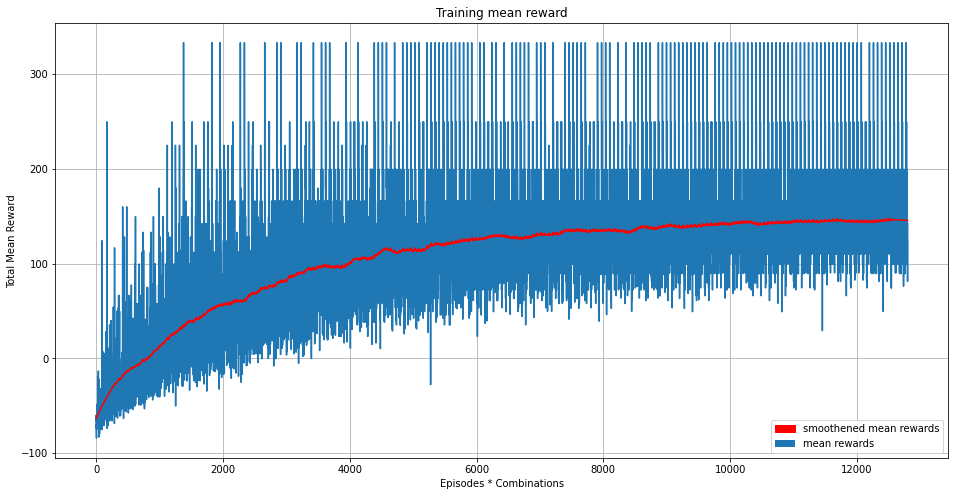

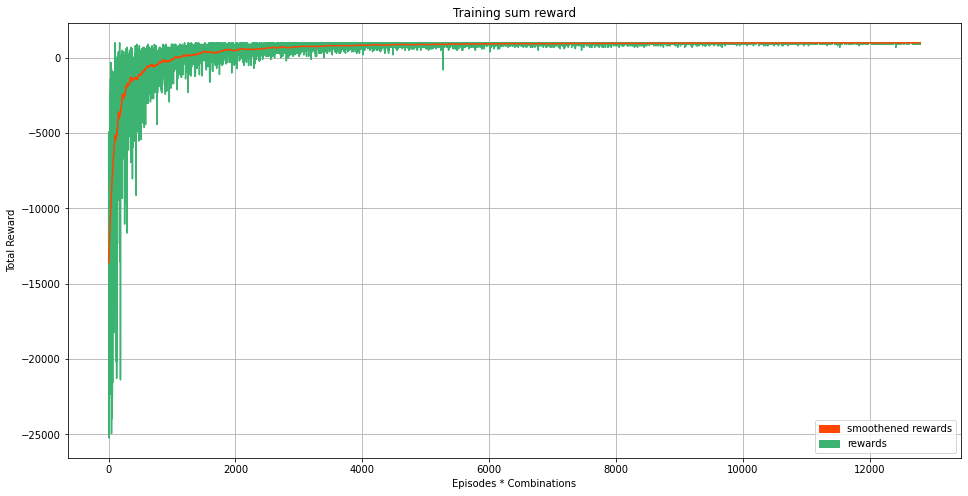

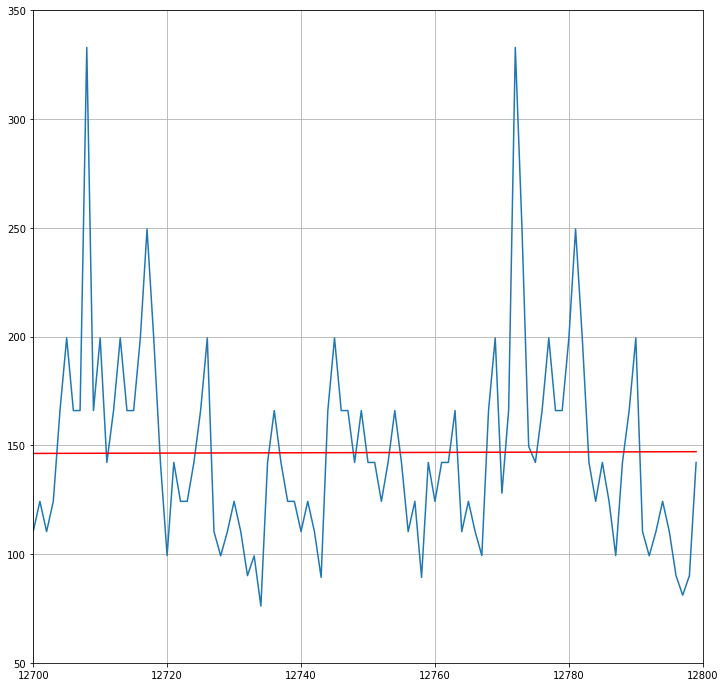

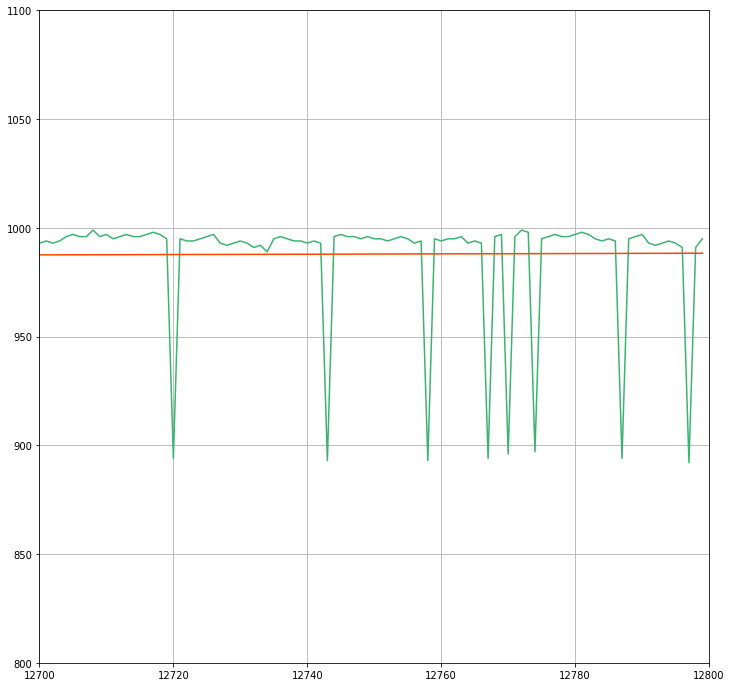

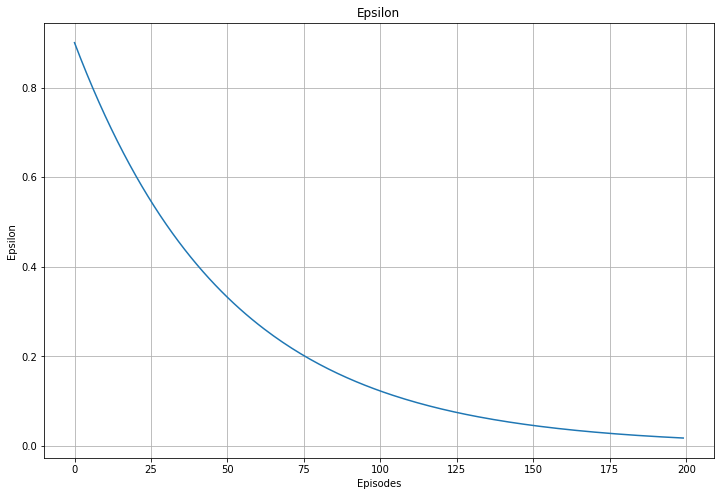

In [ ]:
# Plot the mean reward got from the training

fig, ax = plt.subplots(figsize = (16, 8))
red_patch = mpatches.Patch(color = 'red', label = 'smoothened mean rewards')
blue_patch = mpatches.Patch( label = 'mean rewards')
plt.legend(handles = [red_patch, blue_patch])
plt.plot(rewards)
plt.plot(savgol_filter(rewards, 501, 2), color = "red")
plt.title("Training mean reward")
plt.xlabel('Episodes * Combinations')
plt.ylabel('Total Mean Reward')
plt.grid()


# Plot the sum reward got from the training

fig, ax = plt.subplots(figsize = (16, 8))
orange_patch = mpatches.Patch(color = 'orangered', label = 'smoothened rewards')
green_patch = mpatches.Patch(color = "mediumseagreen", label = 'rewards',)
plt.legend(handles = [orange_patch, green_patch])
plt.plot(rewards_sum, color = "mediumseagreen")
plt.plot(savgol_filter(rewards_sum, 201, 2), color = "orangered")
plt.title("Training sum reward")
plt.xlabel('Episodes * Combinations')
plt.ylabel('Total Reward')
plt.grid()


# Plot the zoomed mean reward got from the training

fig, ax = plt.subplots(figsize = (12, 12))
plt.plot(rewards)
plt.plot(savgol_filter(rewards, 1001, 2), color = "red")
plt.grid()
plt.ylim(50, 350)
plt.xlim(len(rewards_sum) - (5 * num_dest_idx * (num_pass_idx - 1)), len(rewards_sum));
plt.title("Training Zoom Mean")
plt.xlabel('Episodes * Combinations')
plt.ylabel('Total Reward')


# Plot the zoomed sum reward got from the training

fig, ax = plt.subplots(figsize = (12, 12))
plt.plot(rewards_sum, color = "mediumseagreen")
plt.plot(savgol_filter(rewards_sum, 1001, 2), color = "orangered")
plt.grid()
plt.ylim(800, 1100)
plt.xlim(len(rewards_sum) - (5 * num_dest_idx * (num_pass_idx - 1)), len(rewards_sum));
plt.title("Training Zoom Sum")
plt.xlabel('Episodes * Combinations')
plt.ylabel('Total Reward')


# Epsilon evolution plot

fig, ax = plt.subplots(figsize = (12, 8))
plt.plot(agent.epsilons_)
plt.title("Epsilon")
plt.xlabel('Episodes')
plt.ylabel('Epsilon')
plt.grid()

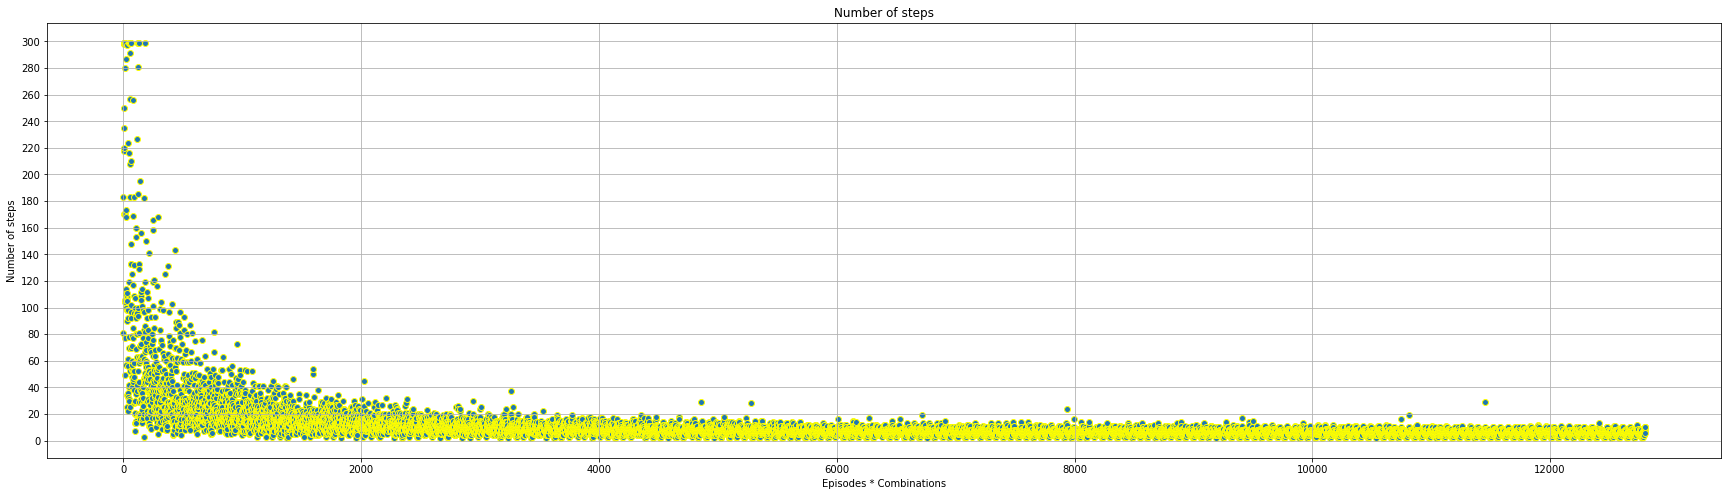

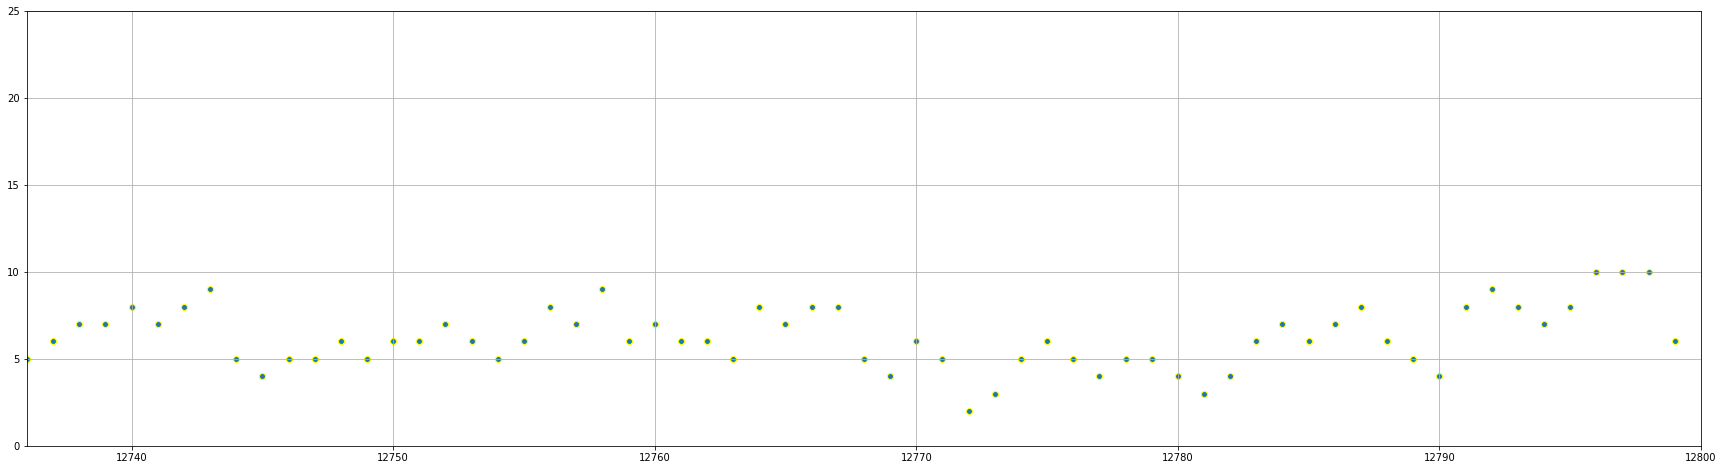

In [ ]:
# Plot the number of steps necessary to complete each task


# Number of steps to complete the task

fig, ax = plt.subplots(figsize = (30, 8))
plt.scatter([range(0, len(act))], act, edgecolors = "yellow" )
plt.title("Number of steps")
plt.xlabel('Episodes * Combinations')
plt.ylabel('Number of steps')
ax.set_yticks(np.arange(0, 301, 20))
plt.grid()


# Zoom to visualize clearly it

fig, ax = plt.subplots(figsize = (30, 8))
plt.scatter([range(0, len(act))], act, edgecolors = "yellow" )
plt.xlim(len(act) - (5 * num_dest_idx * (num_pass_idx - 1)), len(act));
plt.ylim(0, 25)
plt.title("Zoom number of steps")
plt.xlabel('Episodes * Combinations')
plt.ylabel('Number of steps')
plt.grid()


# Evaluation

In [ ]:
# By importing evaluation lists, it's not necessary to execute the evaluation code

if check_evaluation == True:

  f = open("/path/NNeval.pkl", "rb")
  episode_action_e = pickle.load(f)
  episode_pass_idx_e = pickle.load(f)
  episode_new_pass_idx_e = pickle.load(f)
  episode_new_node_e = pickle.load(f)
  episode_dest_idx_e = pickle.load(f)
  episode_rewards_e = pickle.load(f)
  Rewards_e = pickle.load(f)
  act_e = pickle.load(f)
  Rewards_sum_e = pickle.load(f)
  frames = pickle.load(f)

In [ ]:
# Evaluation

if check_evaluation == False:

  frames = []  # Empty list used to display some values


  # Empty lists filled during the evaluation

  episode_action_e = [] 
  episode_pass_idx_e = [] 
  episode_new_pass_idx_e = []
  episode_new_node_e = [] 
  episode_dest_idx_e = [] 
  episode_rewards_e = []
  Rewards_e = []
  act_e = []
  Rewards_sum_e = []


  for k in range(len(locs)):

      for m in range(len(locs)):

          step = 0
          pass_idx = k
          new_pass_idx = k
          dest_idx = m
          state, new_state, new_node, reward = env.reset(pass_idx, dest_idx)  # Reset variables to the initial conditions
          state = np.reshape(int(state), [1,1])
          print("Pass_idx {} and dest_idx {}".format(pass_idx, dest_idx))    


          # Update lists

          episode_action_e.append(int(node))  
          episode_pass_idx_e.append(int(pass_idx))
          episode_new_pass_idx_e.append(new_pass_idx)
          episode_new_node_e.append(int(new_node))
          episode_dest_idx_e.append(int(dest_idx))
          episode_Rewards_e = []  
          episode_Action_e = []

          frames.append({
             'state': state[0][0],
             'episode': 1,
             'step': step,
             'reward': reward
          })


          while True:
                action = int(agent.act(state, explore = False))  # The action is chosen from the output of the NN (exploitation)
      
                new_state, new_node, new_pass_idx, reward, done = env.step(action, pass_idx, new_pass_idx, dest_idx)  # Take an action and observe the outcomes of the step function 

                new_state = np.reshape(int(new_state), [1, 1])  
                state = new_state  

                # Update lists 

                episode_action_e.append(int(action))  
                episode_pass_idx_e.append(int(pass_idx))
                episode_new_pass_idx_e.append(new_pass_idx)
                episode_new_node_e.append(int(new_node))
                episode_dest_idx_e.append(int(dest_idx))
                episode_Action_e.append(int(action))  
                episode_Rewards_e.append(int(reward))
       
                frames.append({
                   'state': state[0][0],
                   'episode': 1,
                   'step': step,
                   'reward': reward
                })

                step += 1
                if done:
                   step = 0
                   break

                if step == 30:
                    step = 0
                    print(" I cannot finish the task Pass_idx {} and dest_idx {}".format(pass_idx, dest_idx))
                    break
                state = new_state

          # Update lists used to plot the number of steps, the mean rewards and the sum rewards

          Rewards_e.append(np.mean(episode_Rewards_e))  
          act_e.append(len(episode_Action_e))
          Rewards_sum_e.append(np.sum(episode_Rewards_e))        

In [ ]:
# To visualize the evolution of state, episode and reward

def print_frames(frames):
  for i, frame in enumerate(frames):
    clear_output(wait=True)
    print(f"Episode: {frame['episode']}")
    print(f"Timestep: {frame['step']}")    
    print(f"State: {frame['state']}")
    print(f"Reward: {frame['reward']}")
    time.sleep(.5)

In [ ]:
# Save results of the evaluation

if check_evaluation == False:

  f = open("NNeval.pkl", "wb")
  pickle.dump(episode_action_e, f)
  pickle.dump(episode_pass_idx_e, f)
  pickle.dump(episode_new_pass_idx_e, f)
  pickle.dump(episode_new_node_e, f)
  pickle.dump(episode_dest_idx_e, f)
  pickle.dump(episode_rewards_e, f)
  pickle.dump(Rewards_e, f)
  pickle.dump(act_e, f)
  pickle.dump(Rewards_sum_e, f)  
  pickle.dump(frames, f)
  f.close()

In [ ]:
# Simultaneous visualization of state, episode, step and reward

print_frames(frames)

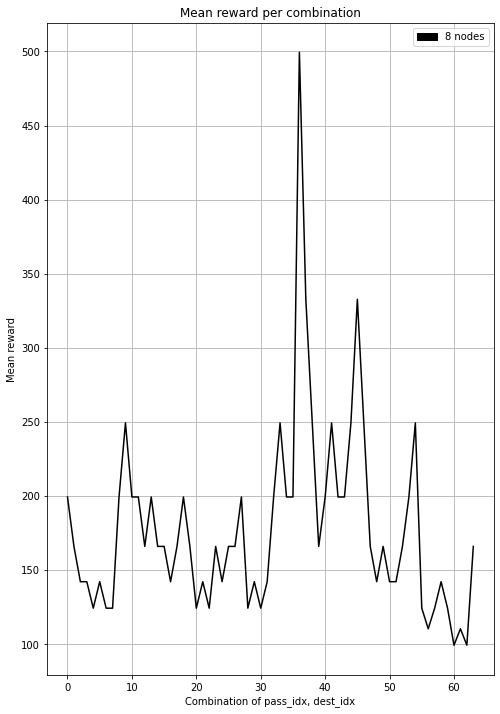

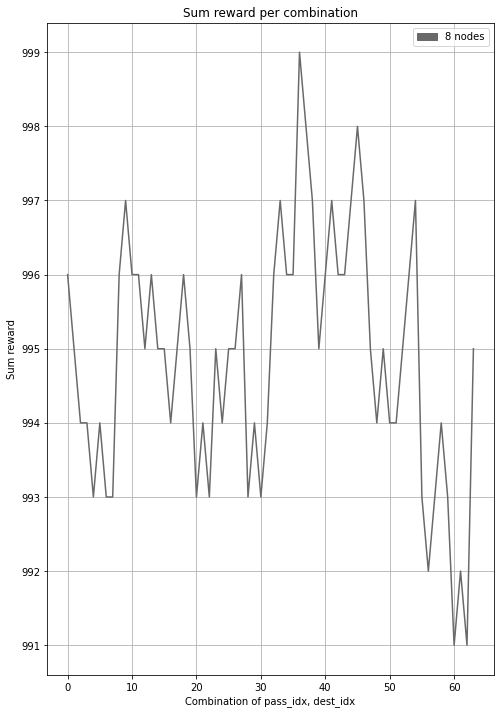

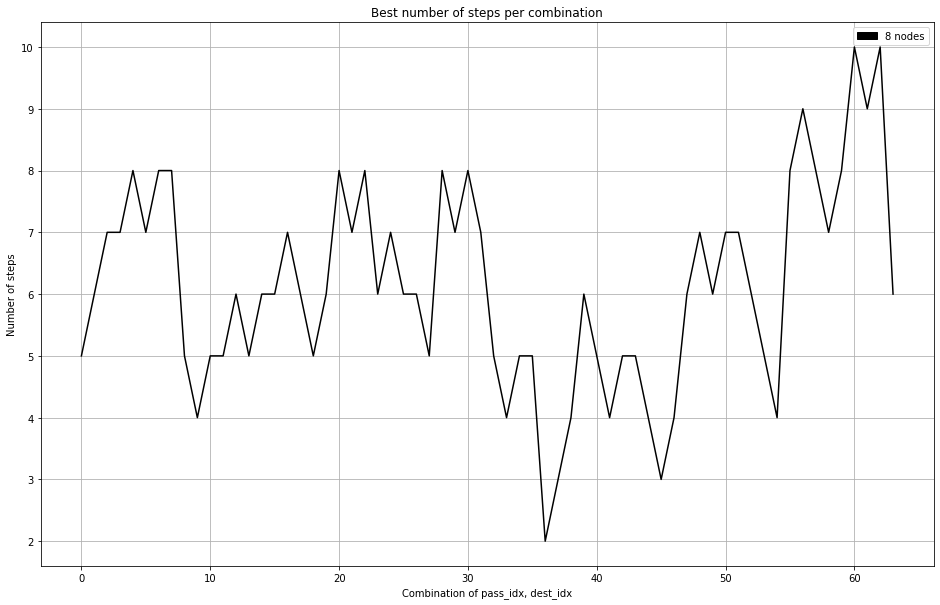

In [ ]:
# Plot the mean reward for each combination

fig, ax = plt.subplots(figsize = (8, 12))
comb = [range(0, 64)]
black_patch = mpatches.Patch(color = "blue", label = '8 nodes')
plt.legend(handles = [black_patch])
plt.plot(Rewards_e, color = "blue")
plt.title("Mean reward per combination")
plt.xlabel('Combination of pass_idx, dest_idx')
plt.ylabel('Mean reward')
plt.grid()


# Plot the sum reward for each combination

fig, ax = plt.subplots(figsize = (16, 10))
comb = [range(0, 64)]
dimgray_patch = mpatches.Patch(color = "navy", label = '8 nodes')
plt.legend(handles = [dimgray_patch])
plt.plot(Rewards_sum_e, color = "navy")
plt.title("Sum reward per combination")
plt.xlabel('Combination of pass_idx, dest_idx')
plt.ylabel('Sum reward')
plt.grid()


# Plot the number of steps for each combination

fig, ax = plt.subplots(figsize = (16, 10))
plt.plot(act_e, color = "blue")
plt.legend(handles = [black_patch])
plt.title("Best number of steps per combination")
plt.xlabel('Combination of pass_idx, dest_idx')
plt.ylabel('Number of steps')
plt.grid()